<a href="https://colab.research.google.com/github/tarunpanda001/EDA/blob/main/Why_Uber_Fails_A_Root_Cause_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement :
Uber has received some complaints from their customers facing problems related to ride cancellations by the driver and non-availability of cars for a specific route in the city.

The uneven supply-demand gap for cabs from City to Airport and vice-versa is causing a bad effect on customer relationships as well as Uber is losing out on its revenue.

The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to tackle the situation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv("uber-data.csv",dayfirst=True,na_values="NA")
df.head(10)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47
5,3879,Airport,1.0,Trip Completed,13-07-2016 21:57:28,13-07-2016 22:28:59
6,4270,Airport,1.0,Trip Completed,14-07-2016 06:15:32,14-07-2016 07:13:15
7,5510,Airport,1.0,Trip Completed,15-07-2016 05:11:52,15-07-2016 06:07:52
8,6248,City,1.0,Trip Completed,15-07-2016 17:57:27,15-07-2016 18:50:51
9,267,City,2.0,Trip Completed,11/7/2016 6:46,11/7/2016 7:25


In [5]:
print("No. of rows: {}".format(df.shape[0]))
print("No. of cols: {}".format(df.shape[1]))

No. of rows: 6745
No. of cols: 6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [7]:
df["Driver id"].nunique()

300

In [8]:
df['Request timestamp_1'] = pd.to_datetime(df['Request timestamp'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df['Request timestamp_2']=pd.to_datetime(df['Request timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Request timestamp']=df['Request timestamp_2'].combine_first(df['Request timestamp_1'])

In [9]:
df['Drop timestamp_1'] = pd.to_datetime(df['Drop timestamp'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df['Drop timestamp_2']=pd.to_datetime(df['Drop timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Drop timestamp']=df['Drop timestamp_2'].combine_first(df['Drop timestamp_1'])

In [10]:
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request timestamp_1,Request timestamp_2,Drop timestamp_1,Drop timestamp_2
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,NaT,2016-07-11 11:51:00,NaT,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,NaT,2016-07-11 17:57:00,NaT,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,NaT,2016-07-12 09:17:00,NaT,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,NaT,2016-07-12 21:08:00,NaT,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,2016-07-13 08:33:16,NaT,2016-07-13 09:25:47,NaT


In [11]:
df.drop(columns=['Request timestamp_1', 'Request timestamp_2',
                 'Drop timestamp_1', 'Drop timestamp_2'],
                  inplace=True)

## Checking for Null Values

In [12]:
df.isnull().sum()/len(df)*100

,0
Request id,0.000000
Pickup point,0.000000
Driver id,39.288362
Status,0.000000
Request timestamp,0.000000
Drop timestamp,58.028169


In [13]:
print("No. of duplicate rows: ", df.duplicated().sum())

No. of duplicate rows:  0


## Feature Engineering

In [15]:
df["RequestHour"]=df["Request timestamp"].dt.hour

In [18]:
def fun(x):
    if x <= 4:
        return "Dawn"
    elif x <= 9:
        return "Early Morning"
    elif x <= 16:
        return "Noon"
    elif x <= 21:
        return "Evening"
    else:
        return "Night"

df["TimeSlot"] = df["RequestHour"].apply(fun)

In [19]:
df["Status"].unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

In [20]:
df["Cab Availability"] = df["Status"].apply(lambda x: "Available" if x=="Trip Completed" else "Not Available")

In [21]:
df.sample(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,RequestHour,TimeSlot,Cab Availability
111,5923,City,12.0,Trip Completed,2016-07-15 10:07:49,2016-07-15 10:50:50,10,Noon,Available
279,1676,Airport,28.0,Trip Completed,2016-07-12 07:44:00,2016-07-12 08:40:00,7,Early Morning,Available
4149,83,City,NaN,No Cars Available,2016-07-11 04:44:00,NaT,4,Dawn,Not Available
830,2914,Airport,85.0,Trip Completed,2016-07-13 06:16:45,2016-07-13 06:51:33,6,Early Morning,Available
2415,5056,Airport,253.0,Trip Completed,2016-07-14 19:26:06,2016-07-14 19:55:39,19,Evening,Available


In [22]:
df["Cab Availability"].value_counts(normalize=True)*100

,proportion
Cab Availability,
Not Available,58.028169
Available,41.971831


Text(0.5, 1.0, 'Frequency of Requests by Hour')

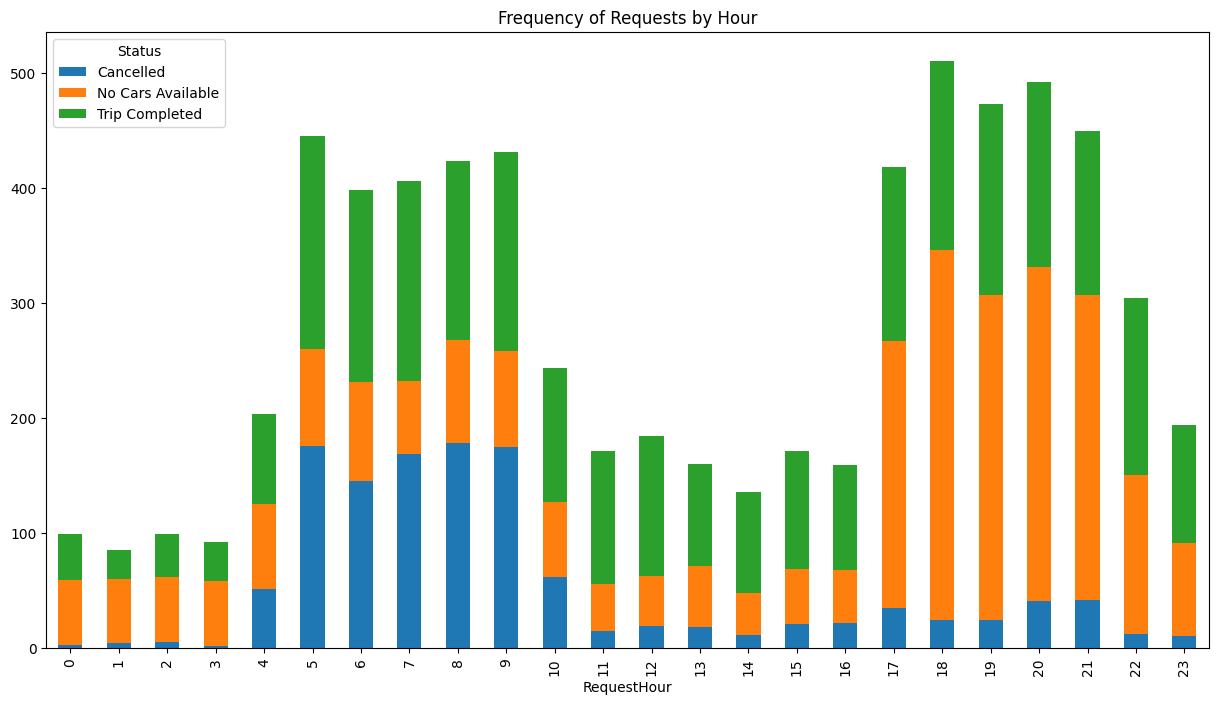

In [25]:
df.groupby(['RequestHour','Status']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Frequency of Requests by Hour')

Observation:

- (5 - 9) Peak of Cancellation
- (17-22) Cars not available

Text(0, 0.5, '')

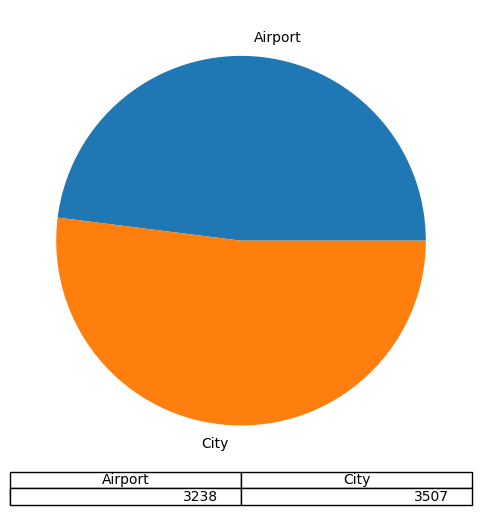

In [26]:
df.groupby(['Pickup point']).size().plot(kind="pie", stacked=True, figsize=(6, 6), table=True)
plt.ylabel("")

Text(0, 0.5, '')

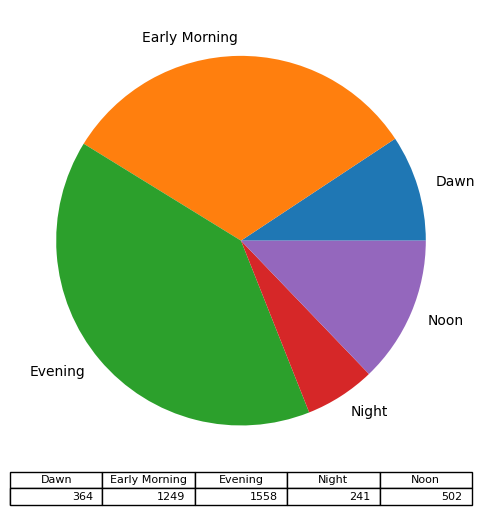

In [27]:
df[(df["Cab Availability"]=="Not Available")].groupby(['TimeSlot']).size().plot(kind="pie", stacked=True, figsize=(6, 6), table=True)
plt.ylabel("")

Observation:
- Late Evenings and Early Mornings are not recommended for Airport-City transport or vice versa.

Text(0.5, 1.0, 'Demand-Supply Gap from Airport to City')

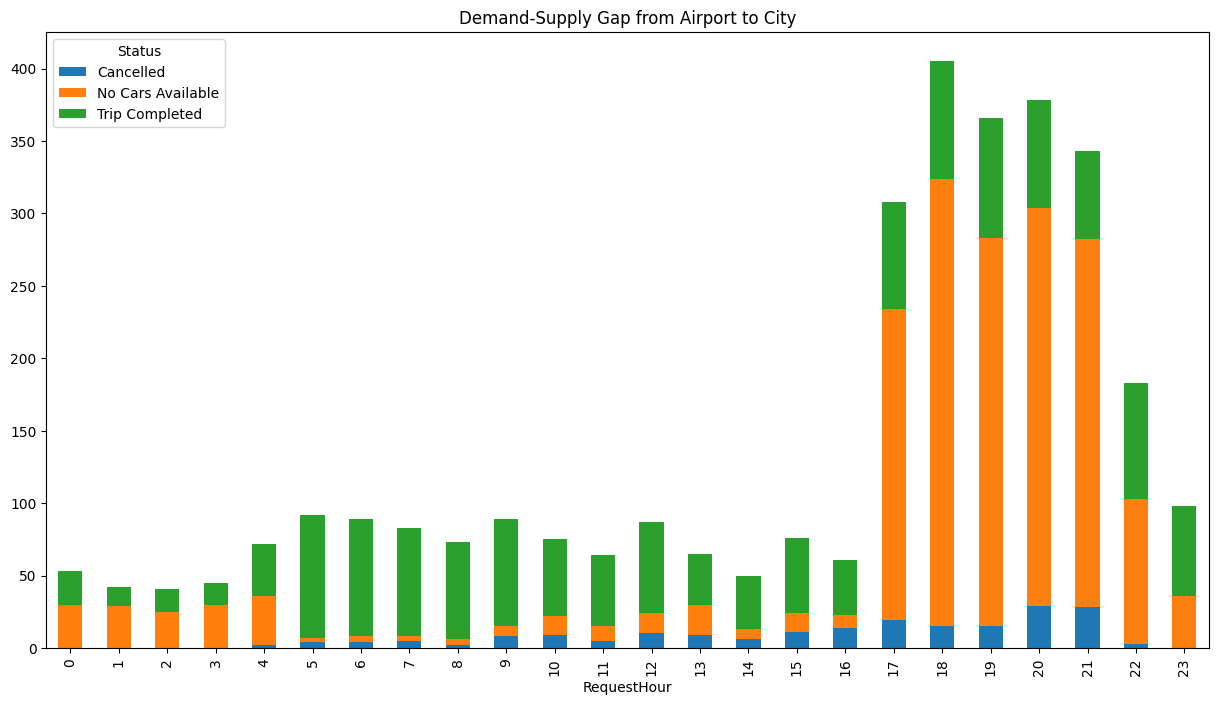

In [28]:
df[(df['Pickup point']=="Airport")].groupby(['RequestHour','Status']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Demand-Supply Gap from Airport to City')

Observation:

There is very high demand for cabs from Airport to City between 5:00 PM – 9:00 PM
But the supply is very less due primarily due to ‘No Cabs Available'

Text(0.5, 1.0, 'Demand-Supply Gap from City to Airport')

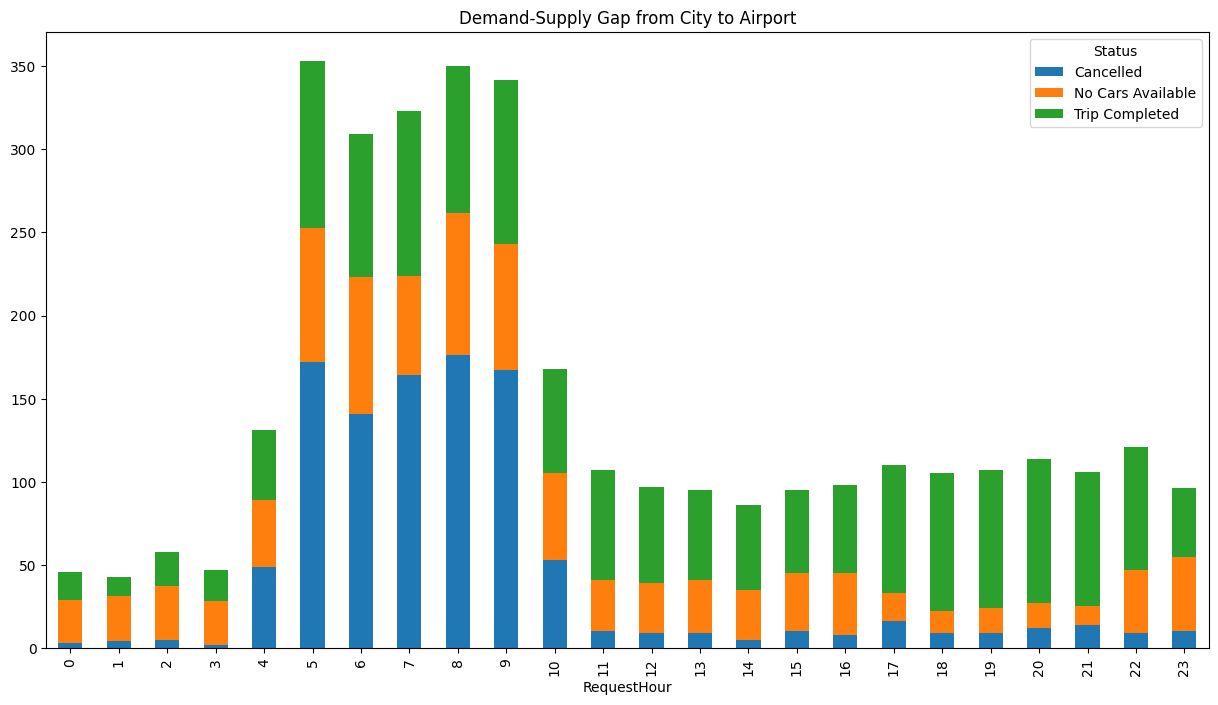

In [29]:
df[(df['Pickup point']=="City")].groupby(['RequestHour','Status']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Demand-Supply Gap from City to Airport')

Observation:

There is very high demand for cabs from City to Airport between 5:00 AM – 9:00 AM
But the supply is very less primarily due to Ride Cancellations

Text(0.5, 1.0, 'Time slots where highest gap exists')

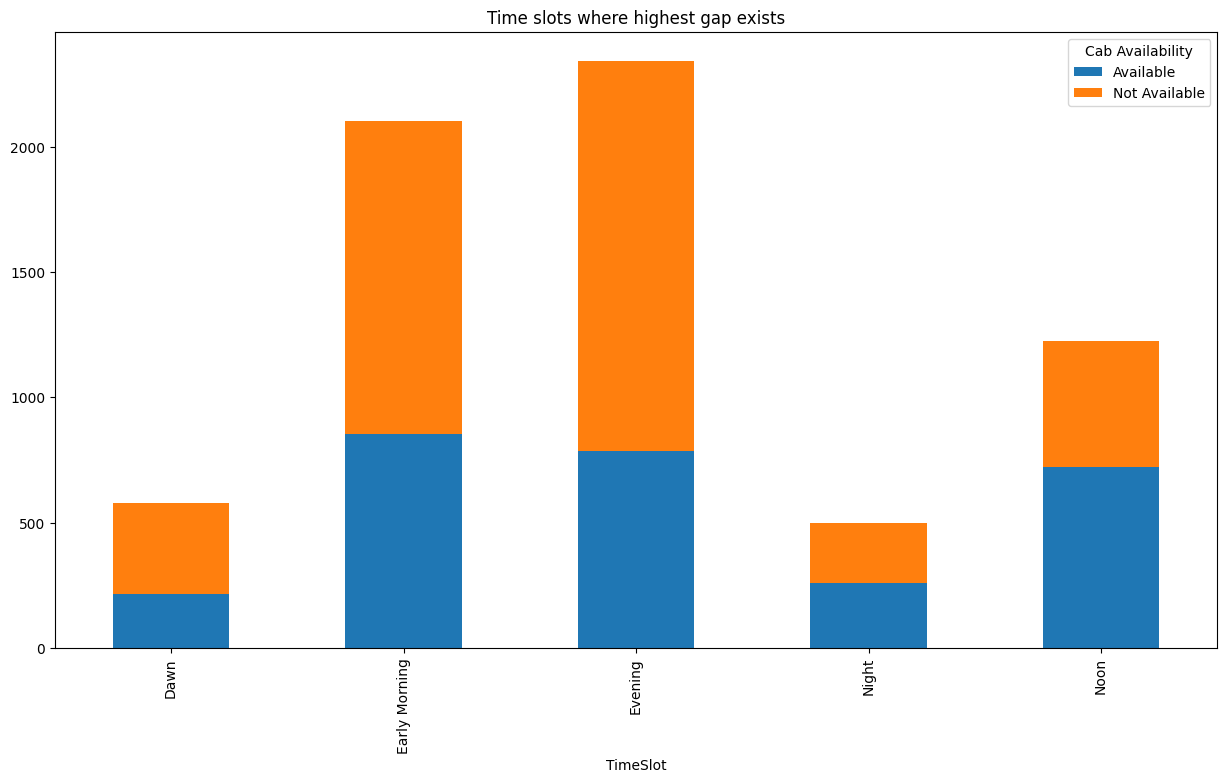

In [30]:
df.groupby(['TimeSlot','Cab Availability']).size().unstack().plot(kind='bar', stacked=True,figsize=(15, 8))
plt.title('Time slots where highest gap exists')

Observation:

Among the assumed time slots, we can see that the Late Evening and Early Morning time slots has got the highest gap.
This means that during evening & morning hours the probability of getting a cab is very less.

## Reason for the supply demand Gap

1. In the Supply-Demand graph from Airport to City, between 5:00 PM to 9:00 PM there is very high demand for cabs because the supply is very low due to ‘No Cars Available’.

2. The ‘No Cars Available’ is due to the fact that in the previous hours fewer people travelled from City – Airport and so fewer cars are available in near Airport.

3. Likewise, in Supply-Demand graph from City – Airport, between 5:00 AM to 9:00 AM, there is very high demand for cabs because the supply is very low due to Ride Cancellations.

4. This is because there were fewer trips to Airport that completed in the previous hours, so now the cabs have to come from a long distance (City) to pickup the passenger and then they have to wait for the passenger’s arrival, so the drivers cancel the trip.

### Recommendations

1. Awarding Incentive for drivers who are waiting at the airport.
2. Have a fleet stationed at the airport/ also can be done for part time drivers.
3. Provide free parking at airport.
4. Refreshment booth for driver waiting at the airport.
5. priority for High fare rides or long-distance rides.
6. Drivers could be compensated for taking the night shifts hence covering the 00:00 – 5:00 time slot.
7. Streaks maintained for consistent performance of such rides andbonus issued

## Direct Cause Vs Root Cause


Direct Cause: Immediate factors that directly contribute to a problem or an event.
For example: In a car accident, the direct cause might be the driver running a red light, which led to the crash.

Root Cause: Underlying factors that give rise to the direct causes.
For example: In the same car accident, the root cause could be inadequate driver training or poor road signage, which led to the driver’s failure to stop at the red light.